# SetFit for Multilabel Text Classification

Put use_small_subset = False for full dataset training.
Put use_small_subset = True if you want to set fixed samples per subset.

Please adjust as needed
- use_small_subset (True if you want to use num_per score)
- dataset_option (which dataset you want to train with)
- num_per_score (probably the more the better)
- num folds (at least 2 but more is better)
- batchsize 
- epochs 
- max_words (?)

In [ ]:
from dotenv import load_dotenv
load_dotenv()
import os
import numpy as np
import torch
from datasets import load_dataset, DatasetDict, Dataset
from transformers import EarlyStoppingCallback
from setfit import SetFitModel, Trainer, TrainingArguments
from sklearn.model_selection import KFold
from collections import defaultdict, Counter
from sklearn.metrics import cohen_kappa_score
import kagglehub
import shutil
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Toggle between full dataset and smaller subset for debugging
use_small_subset = True  # Set to False for full dataset

# Options: "kaggle", "persuade", or "whole"
dataset_option = "whole"  # Choose the dataset to train on

# Number of samples per score (category)
num_per_score = 50  # Adjust as needed for balanced dataset creation
num_folds = 2  # Number of folds for k-fold cross-validation

max_words=4096

huggingface_username = 'HSLU-AICOMP-LearningAgencyLab'
our_model_name = 'automated-essay-scoring-setfit-finetuned'

# Dataset and project configuration
dataset_path = "HSLU-AICOMP-LearningAgencyLab/whole_kaggle_dataset"

os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

# Preprocessing function with
def truncate_text(example):
    words = example["full_text"].split()
    example["text"] = " ".join(words[:max_words]) if len(words) > max_words else example["full_text"]
    return example

# Create a balanced subset with fixed samples per score
def create_balanced_subset(dataset, num_per_score, label_column="score"):
    print(f"Creating a balanced subset with {num_per_score} samples per score...")
    category_samples = defaultdict(list)

    # Group samples by category
    for sample in dataset:
        category_samples[sample[label_column]].append(sample)

    # Select a fixed number of samples per category
    balanced_samples = []
    for category, samples in category_samples.items():
        selected_samples = samples[:num_per_score]  # Limit to num_per_score per category
        balanced_samples.extend(selected_samples)

    return Dataset.from_list(balanced_samples)

# Create k-fold splits with internal 80/20 distribution
def create_kfold_splits(dataset, k=5, test_size=0.2, seed=42):
    print(f"Splitting dataset into {k} folds with 80/20 train-eval distribution...")
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    splits = []
    
    for fold, (train_idx, eval_idx) in enumerate(kf.split(dataset)):
        # Split the current fold into train and eval sets
        train_data = dataset.select(train_idx)
        eval_data = dataset.select(eval_idx)

        # Further split train_data into 80/20 distribution using Hugging Face's method
        split = train_data.train_test_split(test_size=test_size, seed=seed)
        train_split, eval_split = split["train"], split["test"]

        splits.append(DatasetDict({
            "train": train_split,
            "test": eval_split,
        }))
        print(f"Fold {fold + 1}: {len(train_split)} train samples, {len(eval_split)} eval samples.")
    
    return splits

# Load dataset from Hugging Face
print("Loading dataset...")
full_dataset = load_dataset(dataset_path)
print("Dataset loaded successfully!")

# Filter dataset based on user option
if dataset_option == "kaggle":
    print("Training with Kaggle-only dataset (not in Persuade corpus).")
    selected_dataset = full_dataset.filter(lambda x: not x.get("in_persuade_corpus", False))
elif dataset_option == "persuade":
    print("Training with Persuade-only dataset (in Persuade corpus).")
    selected_dataset = full_dataset.filter(lambda x: x.get("in_persuade_corpus", False))
else:  # whole dataset
    print("Training with the whole dataset.")
    selected_dataset = full_dataset

# Print dataset statistics
total_samples = len(selected_dataset["train"])
category_counts = Counter(selected_dataset["train"]["score"])
print(f"\nTotal samples in the selected dataset: {total_samples}")
print(f"Samples per category:")
for score, count in sorted(category_counts.items()):
    print(f"  Score {score}: {count} samples")


Loading dataset...
Dataset loaded successfully!
Training with the whole dataset.

Total samples in the selected dataset: 17307
Samples per category:
  Score 1: 1252 samples
  Score 2: 4723 samples
  Score 3: 6280 samples
  Score 4: 3926 samples
  Score 5: 970 samples
  Score 6: 156 samples


In [2]:
# Use balanced subset if number of samples per score are set
if use_small_subset:
    print("Using a balanced smaller subset for debugging...")
    balanced_subset = create_balanced_subset(selected_dataset["train"], num_per_score=num_per_score)
else:
    balanced_subset = selected_dataset["train"]

# Apply truncation preprocessing
print(f"Truncating text to {max_words} words...")
balanced_subset = balanced_subset.map(truncate_text, batched=False)

# Create k-fold splits
kfold_splits = create_kfold_splits(balanced_subset, k=num_folds)

# Preprocess dataset for training
def preprocess_dataset(dataset):
    print("Converting labels and filtering columns...")
    dataset = dataset.map(lambda x: {"label": int(x["score"])})
    columns_to_keep = ["text", "label"]
    return dataset.remove_columns([col for col in dataset.column_names if col not in columns_to_keep])

# Preprocess each fold
for fold, split in enumerate(kfold_splits):
    print(f"Preprocessing Fold {fold + 1}...")
    kfold_splits[fold]["train"] = preprocess_dataset(split["train"])
    kfold_splits[fold]["test"] = preprocess_dataset(split["test"])

# Verify dataset sizes
print(f"Number of folds: {num_folds}")
for fold, split in enumerate(kfold_splits):
    print(f"Fold {fold + 1}: {len(split['train'])} train samples, {len(split['test'])} eval samples.")

def compute_qwk(y_pred, y_true):
    y_pred = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred
    return {"qwk": cohen_kappa_score(y_true, y_pred, weights='quadratic')}

# Load your specified model
print("Loading your specified model...")
model_id = "HSLU-AICOMP-LearningAgencyLab/automated-essay-scoring-setfit"
model = SetFitModel.from_pretrained(model_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded and moved to {device}.")

# Optimized training arguments
batch_size = 2  # Small batch size for testing
num_epochs = 3  # Reduce epochs for faster iteration during debugging
use_amp = True  # Enable mixed precision training

args = TrainingArguments(
    batch_size=batch_size,
    num_epochs=num_epochs,
    use_amp=use_amp,
    report_to=None,  # Disable W&B logging for faster debugging
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Trainer setup and training on the first fold for demonstration
print("Setting up the Trainer...")
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=kfold_splits[0]["train"],  # Use only the first fold for demonstration
    eval_dataset=kfold_splits[0]["test"],
    metric=compute_qwk,
    column_mapping={"text": "text", "label": "label"},
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

for fold, split in enumerate(kfold_splits):
    print(f"Training Fold {fold + 1}...")
    trainer.train_dataset = kfold_splits[fold]["train"]
    trainer.eval_dataset = kfold_splits[fold]["test"]
    trainer.train()

    # Save the best model for the fold
    trainer.push_to_hub(f"{huggingface_username}/{our_model_name}", private=True)

    # Release old model to free GPU memory
    del model
    torch.cuda.empty_cache()
    
    # Reload the best model for the next fold
    model = SetFitModel.from_pretrained(f"{huggingface_username}/{our_model_name}")
    model.to(device)
    trainer.model = model
    print(f"Model for Fold {fold + 1} reloaded.")

Using a balanced smaller subset for debugging...
Creating a balanced subset with 50 samples per score...
Truncating text to 4096 words...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Splitting dataset into 2 folds with 80/20 train-eval distribution...
Fold 1: 120 train samples, 30 eval samples.
Fold 2: 120 train samples, 30 eval samples.
Preprocessing Fold 1...
Converting labels and filtering columns...


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Converting labels and filtering columns...


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Preprocessing Fold 2...
Converting labels and filtering columns...


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Converting labels and filtering columns...


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Number of folds: 2
Fold 1: 120 train samples, 30 eval samples.
Fold 2: 120 train samples, 30 eval samples.
Loading your specified model...


Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.


Model loaded and moved to cuda.
Setting up the Trainer...


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Training Fold 1...


***** Running training *****
  Num unique pairs = 11924
  Batch size = 2
  Num epochs = 3
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: leo1212 (hslu_nlp). Use `wandb login --relogin` to force relogin
/home/leonkrug/anaconda3/envs/aicomp/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


  0%|          | 0/8943 [00:00<?, ?it/s]

Input ids are automatically padded to be a multiple of `config.attention_window`: 512


{'embedding_loss': 0.2537, 'grad_norm': 0.5783407688140869, 'learning_rate': 2.2346368715083798e-08, 'epoch': 0.0}
{'embedding_loss': 0.0338, 'grad_norm': 0.03836971893906593, 'learning_rate': 1.4816103379721672e-05, 'epoch': 1.0}


  0%|          | 0/173 [00:00<?, ?it/s]

{'eval_embedding_loss': 0.20453353226184845, 'eval_embedding_runtime': 66.2863, 'eval_embedding_samples_per_second': 10.44, 'eval_embedding_steps_per_second': 2.61, 'epoch': 1.0}


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

{'embedding_loss': 0.009, 'grad_norm': 0.004601947497576475, 'learning_rate': 7.408051689860836e-06, 'epoch': 2.0}


  0%|          | 0/173 [00:00<?, ?it/s]

{'eval_embedding_loss': 0.17847907543182373, 'eval_embedding_runtime': 64.8847, 'eval_embedding_samples_per_second': 10.665, 'eval_embedding_steps_per_second': 2.666, 'epoch': 2.0}
{'embedding_loss': 0.0, 'grad_norm': 0.004803077783435583, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/173 [00:00<?, ?it/s]

{'eval_embedding_loss': 0.17950206995010376, 'eval_embedding_runtime': 65.0505, 'eval_embedding_samples_per_second': 10.638, 'eval_embedding_steps_per_second': 2.659, 'epoch': 3.0}
{'train_runtime': 6427.4004, 'train_samples_per_second': 5.566, 'train_steps_per_second': 1.391, 'train_loss': 0.01430612819355319, 'epoch': 3.0}


model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model_head.pkl:   0%|          | 0.00/37.8k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/124k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

model_head.pkl:   0%|          | 0.00/37.8k [00:00<?, ?B/s]

Model for Fold 1 reloaded.
Training Fold 2...


***** Running training *****
  Num unique pairs = 11918
  Batch size = 2
  Num epochs = 3


  0%|          | 0/8940 [00:00<?, ?it/s]

{'embedding_loss': 0.0087, 'grad_norm': 8.307008743286133, 'learning_rate': 2.237136465324385e-08, 'epoch': 0.0}
{'embedding_loss': 0.0276, 'grad_norm': 0.0008072669734247029, 'learning_rate': 1.4814814814814815e-05, 'epoch': 1.0}


  0%|          | 0/178 [00:00<?, ?it/s]

{'eval_embedding_loss': 0.22545726597309113, 'eval_embedding_runtime': 67.7821, 'eval_embedding_samples_per_second': 10.475, 'eval_embedding_steps_per_second': 2.626, 'epoch': 1.0}
{'embedding_loss': 0.0073, 'grad_norm': 0.006482354365289211, 'learning_rate': 7.4074074074074075e-06, 'epoch': 2.0}


  0%|          | 0/178 [00:00<?, ?it/s]

{'eval_embedding_loss': 0.2426733374595642, 'eval_embedding_runtime': 67.7373, 'eval_embedding_samples_per_second': 10.482, 'eval_embedding_steps_per_second': 2.628, 'epoch': 2.0}
{'embedding_loss': 0.0, 'grad_norm': 0.009506169706583023, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/178 [00:00<?, ?it/s]

{'eval_embedding_loss': 0.2341785728931427, 'eval_embedding_runtime': 67.7601, 'eval_embedding_samples_per_second': 10.478, 'eval_embedding_steps_per_second': 2.627, 'epoch': 3.0}
{'train_runtime': 6060.2963, 'train_samples_per_second': 5.9, 'train_steps_per_second': 1.475, 'train_loss': 0.011631697506520905, 'epoch': 3.0}


/home/leonkrug/anaconda3/envs/aicomp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model_head.pkl:   0%|          | 0.00/37.8k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.97k [00:00<?, ?B/s]

model_head.pkl:   0%|          | 0.00/37.8k [00:00<?, ?B/s]

Model for Fold 2 reloaded.


In [3]:
dataset_name = 'learning-agency-lab-automated-essay-scoring-2_V3'

dataset_with_split = load_dataset(f"{huggingface_username}/{dataset_name}")

In [4]:
def count_words(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return len(words)

def truncate_text(text, max_words=384):
    words = text.split()
    return ' '.join(words[:max_words])

def subsample_dataset(dataset, split='train', score_column='score', num_per_score=15, max_words=384):
    reduced_dataset_list = []

    for score in range(1, 7):
        filtered = dataset[split].filter(lambda x: x[score_column] == score)
        filtered = filtered.map(lambda x: {'text': truncate_text(x['full_text'], max_words) if count_words(x['full_text']) > max_words else x['full_text']})

        if len(filtered) > 0:
            sample_count = min(len(filtered), num_per_score)
            reduced_dataset_list.append(filtered.shuffle(seed=42).select(range(sample_count)))

    reduced_dataset = Dataset.from_dict({k: sum([d[k] for d in reduced_dataset_list], []) for k in reduced_dataset_list[0].column_names})
    return reduced_dataset

def preprocess_datasets(num_per_score, max_words, fullEvalSet=False):

    eval_num_per_score = num_per_score
    if fullEvalSet == True:
        eval_num_per_score = 10000

    reduced_dataset_train = subsample_dataset(dataset_with_split, split='train', num_per_score=num_per_score, max_words=max_words)
    reduced_dataset_eval = subsample_dataset(dataset_with_split, split='eval', num_per_score=eval_num_per_score, max_words=max_words)

    def convert_label(record):
        record['label'] = int(record['score'])
        return record

    train_dataset = reduced_dataset_train.map(convert_label)
    eval_dataset = reduced_dataset_eval.map(convert_label)

    columns_to_keep = ['text', 'label']
    train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in columns_to_keep])
    eval_dataset = eval_dataset.remove_columns([col for col in eval_dataset.column_names if col not in columns_to_keep])

    train_dataset = train_dataset.map(lambda x: {"label": int(x["label"])})
    eval_dataset = eval_dataset.map(lambda x: {"label": int(x["label"])})
    return train_dataset, eval_dataset

In [5]:
_, full_eval_dataset = preprocess_datasets(num_per_score, max_words, fullEvalSet=True)

metrics = trainer.evaluate(full_eval_dataset)
qwk_score = metrics.get("qwk", -1)
metrics

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

Applying column mapping to the evaluation dataset
***** Running evaluation *****


{'qwk': 0.7397646251669125}

In [ ]:
def evaluate_with_confusion_matrix(model, eval_dataset, class_labels, print_examples=False):

    # Extract text and true labels from the dataset
    print("Generating predictions...")
    eval_texts = eval_dataset["text"]
    true_labels = eval_dataset["label"]
    
    # Use the model to predict labels
    pred_labels = model.predict(eval_texts)
    
    # Compute confusion matrix
    print("Calculating confusion matrix...")
    cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(len(class_labels)))

    # Print true vs predicted labels
    if print_examples:
        print("\nPredicted vs True Labels (first 20 examples):")
        for i, (text, true, pred) in enumerate(zip(eval_texts, true_labels, pred_labels)):
            print(f"Example {i + 1}:")
            print(f"  Text: {text[:100]}...")  # Truncated text for readability
            print(f"  True Label: {class_labels[true]} - Predicted Label: {class_labels[pred]}\n")
            if i >= 19:  # Show only the first 20 examples
                break

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap="Blues", ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

    return cm  # Return confusion matrix for further analysis if needed


***** Running evaluation *****


Evaluating the model on Fold 1...
Generating confusion matrix and predictions...
Generating predictions...
Calculating confusion matrix...

Predicted vs True Labels (first 20 examples):
Example 1:
  Text: I think we should keep the electoral college be cause people can vote on electors and  not the actua...
  True Label: Score 2 - Predicted Label: Score 3

Example 2:
  Text: Venus is the closest planet to Earth in terms of density and size, and accasionally the closest in d...
  True Label: Score 2 - Predicted Label: Score 2

Example 3:
  Text: My position on the driverless cars are dumb if you ask me. Because what some people can't afford thi...
  True Label: Score 2 - Predicted Label: Score 3

Example 4:
  Text: Honestly, who would think there is "Alien Form" on Mars, I mean some of the people are just plain st...
  True Label: Score 2 - Predicted Label: Score 3

Example 5:
  Text: According to the article, I support the author in studying Venus. I believe this is a great idea bec...

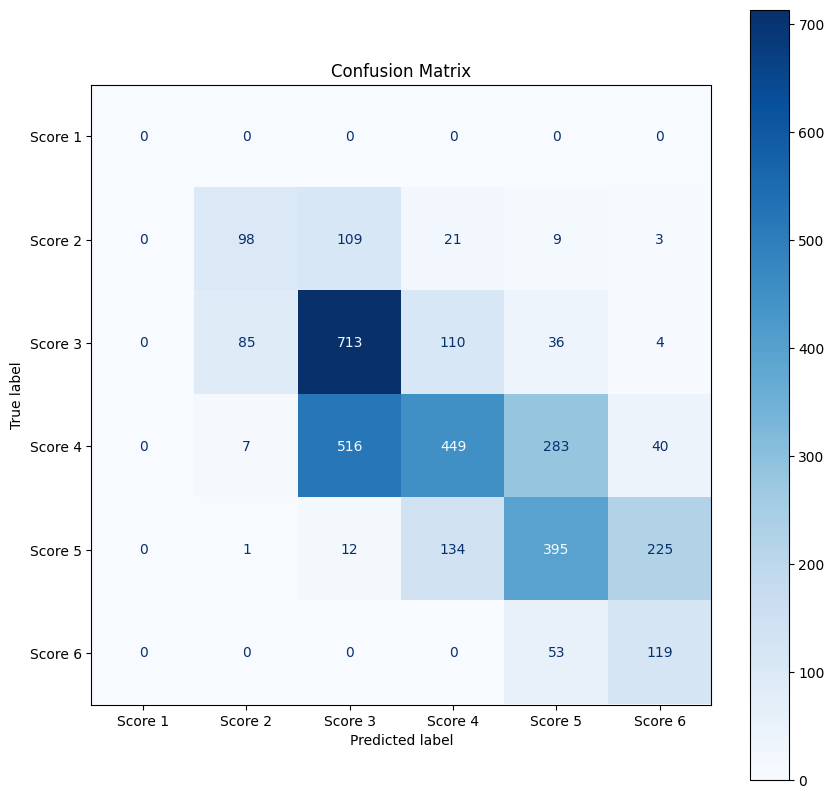

Evaluation results: {'qwk': 0.7458703939008895}


In [9]:
# Define the class labels explicitly
class_labels = ["Score 1", "Score 2", "Score 3", "Score 4", "Score 5", "Score 6"]

# Evaluate the model and display the confusion matrix
print("Evaluating the model on Fold 1...")
metrics = trainer.evaluate()

# Generate confusion matrix and print true vs predicted labels
print("Generating confusion matrix and predictions...")
confusion_matrix_result = evaluate_with_confusion_matrix(
    model, full_eval_dataset, class_labels, print_examples=True
)

# Print evaluation results
print("Evaluation results:", metrics)


And once the model is trained, you can push it to the Hub:

In [8]:
trainer.push_to_hub(f"{huggingface_username}/{our_model_name}", private=True)

CommitInfo(commit_url='https://huggingface.co/HSLU-AICOMP-LearningAgencyLab/automated-essay-scoring-setfit-finetuned/commit/2fa6d618a46bfd140d5ca98e3a99e66802f18d5f', commit_message='Add SetFit model', commit_description='', oid='2fa6d618a46bfd140d5ca98e3a99e66802f18d5f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/HSLU-AICOMP-LearningAgencyLab/automated-essay-scoring-setfit-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='HSLU-AICOMP-LearningAgencyLab/automated-essay-scoring-setfit-finetuned'), pr_revision=None, pr_num=None)

Upload to KaggleHub

In [10]:
from setfit import SetFitModel

model = SetFitModel.from_pretrained(f"{huggingface_username}/{our_model_name}")

README.md:   0%|          | 0.00/4.71k [00:00<?, ?B/s]

In [11]:
VARIATION_SLUG = 'default'

LOCAL_MODEL_DIR = f"../src/models/{our_model_name}"
model.save_pretrained(LOCAL_MODEL_DIR)

# Compress the model directory (optional but helpful for large files)
shutil.make_archive(our_model_name, 'zip', LOCAL_MODEL_DIR)

kagglehub.model_upload(
  handle = f"leo1212abc/{our_model_name}/transformers/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = f"{num_folds}-fold; Metrics: {str(metrics)}")

Uploading Model https://www.kaggle.com/models/leo1212abc/automated-essay-scoring-setfit-finetuned/transformers/default ...
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/config_setfit.json


Uploading: 100%|██████████| 53.0/53.0 [00:00<00:00, 129B/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/config_setfit.json (53B)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/tokenizer_config.json


Uploading: 100%|██████████| 1.41k/1.41k [00:00<00:00, 3.94kB/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/tokenizer_config.json (1KB)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/tokenizer.json


Uploading: 100%|██████████| 3.56M/3.56M [00:01<00:00, 2.72MB/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/tokenizer.json (3MB)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/vocab.json


Uploading: 100%|██████████| 798k/798k [00:01<00:00, 796kB/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/vocab.json (780KB)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/README.md


Uploading: 100%|██████████| 4.23k/4.23k [00:00<00:00, 11.1kB/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/README.md (4KB)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/config_sentence_transformers.json


Uploading: 100%|██████████| 201/201 [00:00<00:00, 565B/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/config_sentence_transformers.json (201B)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/config.json


Uploading: 100%|██████████| 923/923 [00:00<00:00, 2.55kB/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/config.json (923B)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/modules.json


Uploading: 100%|██████████| 229/229 [00:00<00:00, 664B/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/modules.json (229B)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/special_tokens_map.json


Uploading: 100%|██████████| 958/958 [00:00<00:00, 2.68kB/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/special_tokens_map.json (958B)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/merges.txt


Uploading: 100%|██████████| 456k/456k [00:00<00:00, 505kB/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/merges.txt (446KB)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/model.safetensors


Uploading: 100%|██████████| 595M/595M [00:14<00:00, 40.2MB/s] 

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/model.safetensors (567MB)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/sentence_bert_config.json


Uploading: 100%|██████████| 54.0/54.0 [00:00<00:00, 153B/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/sentence_bert_config.json (54B)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/model_head.pkl


Uploading: 100%|██████████| 37.8k/37.8k [00:00<00:00, 89.3kB/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/model_head.pkl (37KB)
Starting upload for file ../src/models/automated-essay-scoring-setfit-finetuned/1_Pooling/config.json


Uploading: 100%|██████████| 296/296 [00:00<00:00, 811B/s]

Upload successful: ../src/models/automated-essay-scoring-setfit-finetuned/1_Pooling/config.json (296B)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/leo1212abc/automated-essay-scoring-setfit-finetuned/transformers/default


In [ ]:
# from dotenv import load_dotenv
# load_dotenv()
# import os
# import torch
# from datasets import load_dataset, DatasetDict, Dataset
# from transformers import EarlyStoppingCallback
# from setfit import SetFitModel, Trainer, TrainingArguments
# from sklearn.model_selection import KFold
# from collections import defaultdict, Counter

# # Toggle between full dataset and smaller subset for debugging
# use_small_subset = True  # Set to False for full dataset

# # Options: "kaggle", "persuade", or "whole"
# dataset_option = "whole"  # Choose the dataset to train on

# # Number of samples per score (category)
# num_per_score = 10  # Adjust as needed for balanced dataset creation
# num_folds = 5  # Number of folds for k-fold cross-validation

# # Dataset and project configuration
# dataset_path = "HSLU-AICOMP-LearningAgencyLab/whole_kaggle_dataset"

# # Preprocessing function
# def truncate_text(example):
#     words = example["full_text"].split()
#     example["text"] = " ".join(words[:max_words]) if len(words) > max_words else example["full_text"]
#     return example

# # Create a balanced subset with fixed samples per score
# def create_balanced_subset(dataset, num_per_score, label_column="score"):
#     print(f"Creating a balanced subset with {num_per_score} samples per score...")
#     category_samples = defaultdict(list)

#     # Group samples by category
#     for sample in dataset:
#         category_samples[sample[label_column]].append(sample)

#     # Select a fixed number of samples per category
#     balanced_samples = []
#     for category, samples in category_samples.items():
#         selected_samples = samples[:num_per_score]  # Limit to num_per_score per category
#         balanced_samples.extend(selected_samples)

#     return Dataset.from_list(balanced_samples)

# # Create k-fold splits with internal 80/20 distribution
# def create_kfold_splits(dataset, k=5, test_size=0.2, seed=42):
#     print(f"Splitting dataset into {k} folds with 80/20 train-eval distribution...")
#     kf = KFold(n_splits=k, shuffle=True, random_state=seed)
#     splits = []
    
#     for fold, (train_idx, eval_idx) in enumerate(kf.split(dataset)):
#         # Split the current fold into train and eval sets
#         train_data = dataset.select(train_idx)
#         eval_data = dataset.select(eval_idx)

#         # Further split train_data into 80/20 distribution using Hugging Face's method
#         split = train_data.train_test_split(test_size=test_size, seed=seed)
#         train_split, eval_split = split["train"], split["test"]

#         splits.append(DatasetDict({
#             "train": train_split,
#             "test": eval_split,
#         }))
#         print(f"Fold {fold + 1}: {len(train_split)} train samples, {len(eval_split)} eval samples.")
    
#     return splits

# # Load dataset from Hugging Face
# print("Loading dataset...")
# full_dataset = load_dataset(dataset_path)
# print("Dataset loaded successfully!")

# # Filter dataset based on user option
# if dataset_option == "kaggle":
#     print("Training with Kaggle-only dataset (not in Persuade corpus).")
#     selected_dataset = full_dataset.filter(lambda x: not x.get("in_persuade_corpus", False))
# elif dataset_option == "persuade":
#     print("Training with Persuade-only dataset (in Persuade corpus).")
#     selected_dataset = full_dataset.filter(lambda x: x.get("in_persuade_corpus", False))
# else:  # whole dataset
#     print("Training with the whole dataset.")
#     selected_dataset = full_dataset

# # Print dataset statistics
# total_samples = len(selected_dataset["train"])
# category_counts = Counter(selected_dataset["train"]["score"])
# print(f"\nTotal samples in the selected dataset: {total_samples}")
# print(f"Samples per category:")
# for score, count in sorted(category_counts.items()):
#     print(f"  Score {score}: {count} samples")




Loading dataset...
Dataset loaded successfully!
Training with the whole dataset.

Total samples in the selected dataset: 17307
Samples per category:
  Score 1: 1252 samples
  Score 2: 4723 samples
  Score 3: 6280 samples
  Score 4: 3926 samples
  Score 5: 970 samples
  Score 6: 156 samples
